# Stock Price Prediction Using Recurrent Neural Networks with TensorFlow & Keras

In [36]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

import warnings

warnings.filterwarnings('ignore')

In [4]:
# Load Stock Market Data

df = pd.read_csv("Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Volume", "Dividends", "Stock Splits"], axis=1)
     

In [5]:
df.head()

,Open,High,Low,Close
Date,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217
2006-05-26,4.307126,4.348058,4.103398,4.179680
2006-05-30,4.183400,4.184330,3.986184,4.093164
2006-05-31,4.125723,4.219679,4.125723,4.180608
2006-06-01,4.179678,4.474572,4.176887,4.419686


In [6]:
df.tail()

,Open,High,Low,Close
Date,,,,
2021-10-05,347.121403,348.130138,342.497241,342.776886
2021-10-06,339.580960,348.439763,338.682072,348.250000
2021-10-07,349.000000,357.899994,349.000000,353.910004
2021-10-08,356.000000,360.369995,354.209991,354.959991
2021-10-11,353.950012,354.880005,346.899994,347.149994


In [7]:

df.describe()

,Open,High,Low,Close
count,3872.000000,3872.000000,3872.000000,3872.000000
mean,104.896814,105.956054,103.769349,104.882714
std,106.245511,107.303589,105.050064,106.168693
min,3.748967,4.102467,3.739664,4.083861
25%,22.347203,22.637997,22.034458,22.300391
50%,70.810079,71.375896,70.224002,70.856083
75%,147.688448,148.645373,146.822013,147.688438
max,392.653890,400.521479,389.747812,394.685730


The minimum stock price is 4.10, and the highest is  400.5. The mean is at  105.9 and the standard deviation  107.3, which means that stocks have high variance.

In [8]:
#Check for Missing Values
df.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

It seems that the dataset has no missing values.

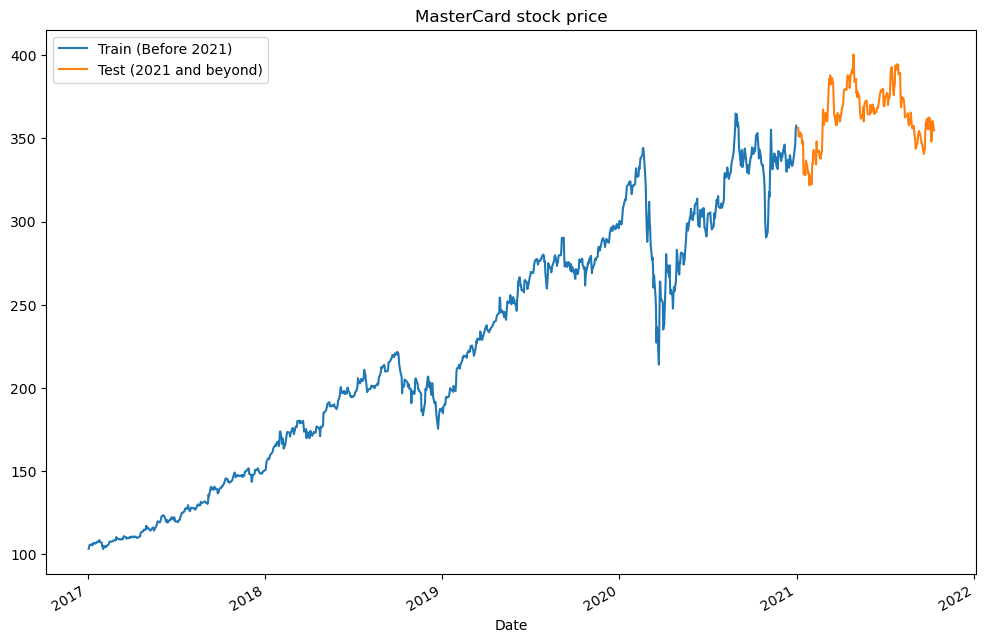

In [9]:
tstart = 2017
tend = 2020

def train_test_plot(df, tstart, tend):
    df.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    df.loc[f"{tend+1}":, "High"].plot(figsize=(12, 8), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(df,tstart,tend)


In [10]:
fig = px.line(y=df.High, x=df.Date)
fig.update_traces(line_color='green')
fig.update_layout(xaxis_title='Date', 
                  yaxis_title='High',
                  title={'text':'Master Card Stock Data', 'y':0.95,
                         'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.9)')

AttributeError: 'DataFrame' object has no attribute 'Date'

# Data Preprocessing

In [12]:
# The train_test_split function divides the dataset into two subsets: training_set and test_set.
def train_test_split(df, tstart, tend):
    train = df.loc[f"{tstart}":f"{tend}", "High"].values
    test = df.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)


# Standardize the dataset
We  use the MinMaxScaler function to standardize our training set, which helps avoid the outliers or anomalies. There are other scalar function to normalize  data and improve model performance.

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = scaler.fit_transform(training_set)


We are using 60 n_steps. We can also reduce or increase the number of steps to optimize model performance.

In [16]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

# Modeling

In [25]:
# The LSTM architecture
model = Sequential()
model.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model.add(Dense(units=1))
# Compiling the model
model.compile(optimizer="RMSprop", loss="mse")

model.summary()
Model: "sequential"


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

# Fit the Model


In [26]:
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0415
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0043
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0039
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0027
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0024
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0021
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0019
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0017
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0013
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0011
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0010
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 9.6036e-04


In [27]:
#Repeatition preprocessing and normalize the test set. 
dataset_total = df.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = scaler.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


From the result above, the we have transformed the test set then split  the dataset into samples, reshape it, predict, and then inverse transformed the predictions back to  standard form.

# Plot Prediction Function

The plot_predictions function will plot a real versus predicted line chart. This will help us visualize the difference between actual and predicted values.c.

In [31]:
def plot_predictions(test_test, predicted):
    plt.figure(figsize=(12,7))
    plt.plot(test_test, color="blue", label="Actual")
    plt.plot(predicted, color="green", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

def return_rmse(test_set, predicted):
    rmse = np.sqrt(mean_squared_error(test_set, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

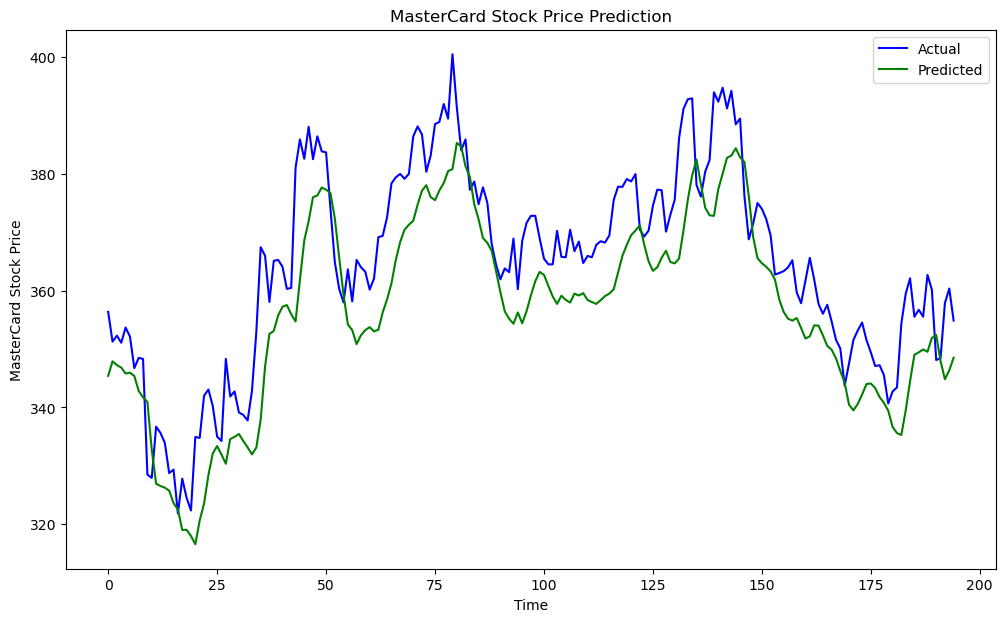

In [32]:
plot_predictions(test_set,predicted_stock_price)


The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

In [33]:
return_rmse(test_set,predicted_stock_price)


The root mean squared error is 10.31.


# Evaluate the  Results

In [41]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [42]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 1 - MAPE


In [43]:
print('Test Loss:', result)
print('Test MAPE:', MAPE)
print('Accuracy:', accuracy)

Test Loss: 0.0015937273856252432
Test MAPE: 0.03404452341781077
Accuracy: 0.9659554765821893


# Modeling With GRU

In [44]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 125)                 │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0563
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0019
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0013
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0014
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0012
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0011
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.8095e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 9.1030e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.4779e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 7.9636e-04
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 8.4273e-04
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.6147e-04
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.1310e-04
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 4

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


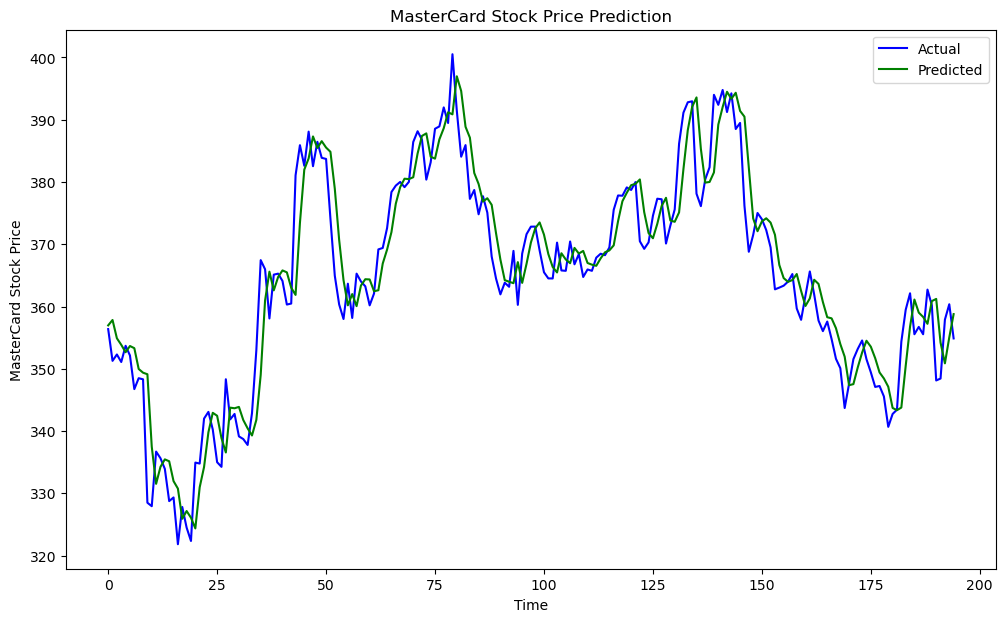

In [46]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = scaler.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)
